# LIWC Test
*(Always to be run as sets up important env)*

In [46]:
!sed -i -e '/[<(]/d' dictionaries/LIWC07-EN.dic

In [47]:
import liwc
parse, category_names = liwc.load_token_parser('dictionaries/LIWC07-EN.dic')


In [48]:
import re
from collections import Counter

def tokenize(text):
    # you may want to use a smarter tokenizer
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

def count_categories(text):
    # Returns a Counter object containing tallies of all LIWC categories
    text = text.lower()
    tokens = tokenize(text)
    counter = Counter(category for token in tokens for category in parse(token))

    # If a category doesn't exist in the text, we need to add it and set the count to 0
    for category in category_names:
        if category not in counter:
            counter[category] = 0

    return counter

gettysburg = "Hello"

print(count_categories(gettysburg))
#=> Counter({'funct': 58, 'pronoun': 18, 'cogmech': 17, ...})

Counter({'social': 1, 'funct': 0, 'pronoun': 0, 'ppron': 0, 'i': 0, 'we': 0, 'you': 0, 'shehe': 0, 'they': 0, 'ipron': 0, 'article': 0, 'verb': 0, 'auxverb': 0, 'past': 0, 'present': 0, 'future': 0, 'adverb': 0, 'preps': 0, 'conj': 0, 'negate': 0, 'quant': 0, 'number': 0, 'swear': 0, 'family': 0, 'friend': 0, 'humans': 0, 'affect': 0, 'posemo': 0, 'negemo': 0, 'anx': 0, 'anger': 0, 'sad': 0, 'cogmech': 0, 'insight': 0, 'cause': 0, 'discrep': 0, 'tentat': 0, 'certain': 0, 'inhib': 0, 'incl': 0, 'excl': 0, 'percept': 0, 'see': 0, 'hear': 0, 'feel': 0, 'bio': 0, 'body': 0, 'health': 0, 'sexual': 0, 'ingest': 0, 'relativ': 0, 'motion': 0, 'space': 0, 'time': 0, 'work': 0, 'achieve': 0, 'leisure': 0, 'home': 0, 'money': 0, 'relig': 0, 'death': 0, 'assent': 0, 'nonfl': 0, 'filler': 0})


# Text Analysis
Go through each entry in the text, and for each entry, add the following information:
- The publish utc timestamp of the comment/post
- The counter of the dimensions

The data structure to be returned will be a pandas dataframe, with the first column being the utc timestamp, and the second column is a counter of the dictionary of LIWC categories

E.g.: ```1000 | Counter({'social': 1...})]```

Everything will also get saved into a csv file after, first column is the utc timestamp, second column the dict

In [49]:
# Set the Reddit Data File Path (JSON)
data_file_path = "data/texas_comments.json"
time_interval_seconds = 0.5 * 30 * 24 * 60 * 60 # half a month
time_start = 1546300801 # 1st January 2019
time_end = 1672531201 # 1st January 2023

run_CSV_creation = True


import tqdm
import pandas as pd
import json
import os

if run_CSV_creation:
    # Intialise the progress bar based on the number of items in the data file
    with open(data_file_path) as f:
        num_lines = sum(1 for line in f)

    pbar = tqdm.tqdm(total=num_lines)

    # Read the data file and add the data to the csv file
    with open(data_file_path) as f:
        with open(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv', 'w') as csv_file:

            # Clear the csv file of any existing data
            csv_file.truncate(0)

            for line in f:
                data = json.loads(line)
                utc_timestamp = data['created_utc']
                LIWC_categories = count_categories(data['body'])

                # Check that the timestamp is within the time interval
                if int(utc_timestamp) < time_start and int(utc_timestamp) > time_end:
                    pbar.update(1)
                    continue

                # Write the data to the csv file
                csv_file.write(f'{utc_timestamp},"{LIWC_categories}"\n')

                # Update the progress bar
                pbar.update(1)
            

    # Close the progress bar
    pbar.close()


100%|██████████| 2684972/2684972 [14:04<00:00, 3179.88it/s]


In [50]:
# Load the data from the csv file into a dataframe
df = pd.read_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LIWC.csv')

# Add headers to the dataframe
df.columns = ['utc_timestamp', 'LIWC_categories']

df.head()

,utc_timestamp,LIWC_categories
0,1217437549,"Counter({'funct': 0, 'pronoun': 0, 'ppron': 0,..."
1,1217454061,"Counter({'funct': 3, 'cogmech': 2, 'pronoun': ..."
2,1217455430,"Counter({'funct': 102, 'cogmech': 43, 'preps':..."
3,1218549486,"Counter({'funct': 21, 'relativ': 8, 'preps': 7..."
4,1219627507,"Counter({'funct': 16, 'cogmech': 6, 'pronoun':..."


# Categorical Analysis
1. Analyse the makeup of categories of discourse over time intervals - think of a stacked bar graph.
2. Analyse the makeup of categories of discourse for each bucket of users - maybe over time intervals

## Makeup of Discourse

In [53]:
import numpy as np

# Calculate time bucket intervals
time_buckets = range(int(time_start), int(time_end) + int(time_interval_seconds), int(time_interval_seconds))

# Print maximum utc_timestamp
# print(df['utc_timestamp'].max())
# print("------------------")
# print(*time_buckets, sep='\n')


# Change the utc_timestamp to the bucket number, e.g. the 0th bucket is between the 0th index and the 1st index of the time_buckets
df['utc_timestamp'] = df['utc_timestamp'].apply(lambda x: np.searchsorted(time_buckets, x) - 1)


df.head()

,utc_timestamp,LIWC_categories
0,-1,"Counter({'funct': 0, 'pronoun': 0, 'ppron': 0,..."
1,-1,"Counter({'funct': 3, 'cogmech': 2, 'pronoun': ..."
2,-1,"Counter({'funct': 102, 'cogmech': 43, 'preps':..."
3,-1,"Counter({'funct': 21, 'relativ': 8, 'preps': 7..."
4,-1,"Counter({'funct': 16, 'cogmech': 6, 'pronoun':..."


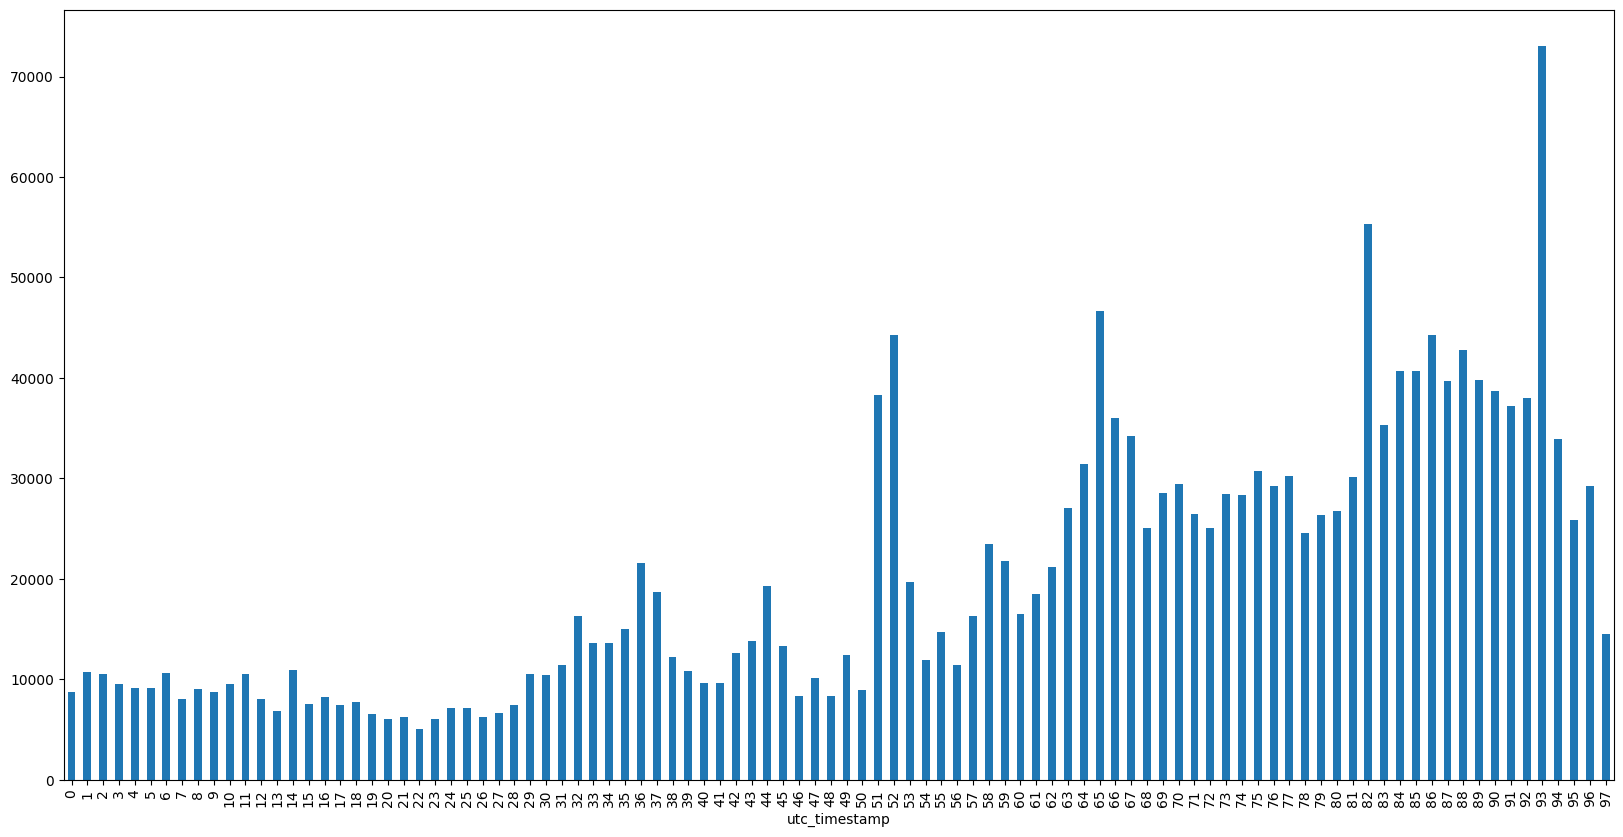

In [54]:
# Graph the number of comments per time bucket
import matplotlib.pyplot as plt

# Delete all rows with a utc_timestamp of -1
df = df[df['utc_timestamp'] != -1]

df['utc_timestamp'].value_counts().sort_index().plot(kind='bar', figsize=(20, 10))
plt.show()

In [55]:
run_aggregation = True

# The LIWC categories stored in a list
data = [
    'funct', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they',
    'ipron', 'article', 'verb', 'auxverb', 'past', 'present', 'future',
    'adverb', 'preps', 'conj', 'negate', 'quant', 'number', 'swear',
    'social', 'family', 'friend', 'humans', 'affect', 'posemo',
    'negemo', 'anx', 'anger', 'sad', 'cogmech', 'insight', 'cause',
    'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl', 'percept',
    'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest',
    'relativ', 'motion', 'space', 'time', 'work', 'achieve', 'leisure',
    'home', 'money', 'relig', 'death', 'assent', 'nonfl', 'filler'
]

# Create a dataframe with the time_bucket and LIWC categories as the column headers
df_tb_liwc = pd.DataFrame(columns=['time_bucket'] + data)

def get_time_bucket_counts(df):

    # Create a row of zeroes for each time_bucket, but time_bucket is the first column and is not a zero
    for i in range(len(time_buckets)):
        df_tb_liwc.loc[i] = [0 for n in range(len(data) + 1)]
        df_tb_liwc.loc[i, 'time_bucket'] = i

    # Start a progress bar
    pbar = tqdm.tqdm(total=len(df))

    # Iterate through each entry in df and aggregate the LIWC categories for each time_bucket
    for index, row in df.iterrows():
        # Get the time_bucket and LIWC_categories
        time_bucket = row['utc_timestamp']
        LIWC_categories = row['LIWC_categories']

        # Convert the LIWC_categories string to a dictionary
        LIWC_categories = eval(LIWC_categories)

        # Add the time_bucket to the dictionary
        LIWC_categories['time_bucket'] = time_bucket

        # For each LIWC category in the dictionary, add the count to the correct time_bucket
        # Aggregate the LIWC category counts for the respective time_bucket
        # But dont sum the time_bucket column
        df_tb_liwc.loc[time_bucket] += pd.Series(LIWC_categories)
        df_tb_liwc.loc[time_bucket, 'time_bucket'] = time_bucket

        
        # Update the progress bar
        pbar.update(1)

    # Close the progress bar
    pbar.close()

    df_tb_liwc.head()

if run_aggregation:
    get_time_bucket_counts(df)


 35%|███▌      | 690104/1968639 [34:33<1:03:14, 336.92it/s]

In [ ]:
# Save the dataframe to a csv file
df_tb_liwc.to_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LICW_aggregated.csv', index=False)

In [ ]:
# Load the dataframe from the csv file
df_tb_liwc = pd.read_csv(f'text_liwc_dimensions/{os.path.basename(data_file_path[:-5])}_LICW_aggregated.csv')

df_tb_liwc.head()

,time_bucket,funct,pronoun,ppron,i,we,you,shehe,they,ipron,...,work,achieve,leisure,home,money,relig,death,assent,nonfl,filler
0,0,582160,150993,86265,30892,7790,26285,7140,14158,64728,...,25728,16928,10075,3376,14148,4303,2175,6329,1579,41
1,1,512714,132359,75220,28910,6611,21948,5880,11869,57139,...,23294,14359,8894,3673,12599,3562,2129,5941,1517,17
2,2,508853,130902,74289,28238,6731,21046,5478,12796,56613,...,23172,14398,9700,3964,13011,3172,2187,5658,1430,30
3,3,485623,124521,69950,25561,6505,19695,6600,11588,54571,...,20441,13278,8542,3474,10183,2711,2152,5174,1269,23
4,4,446412,114894,65119,23903,6121,17431,7749,9915,49775,...,18527,12879,7443,3364,10680,2245,2628,4686,1228,26


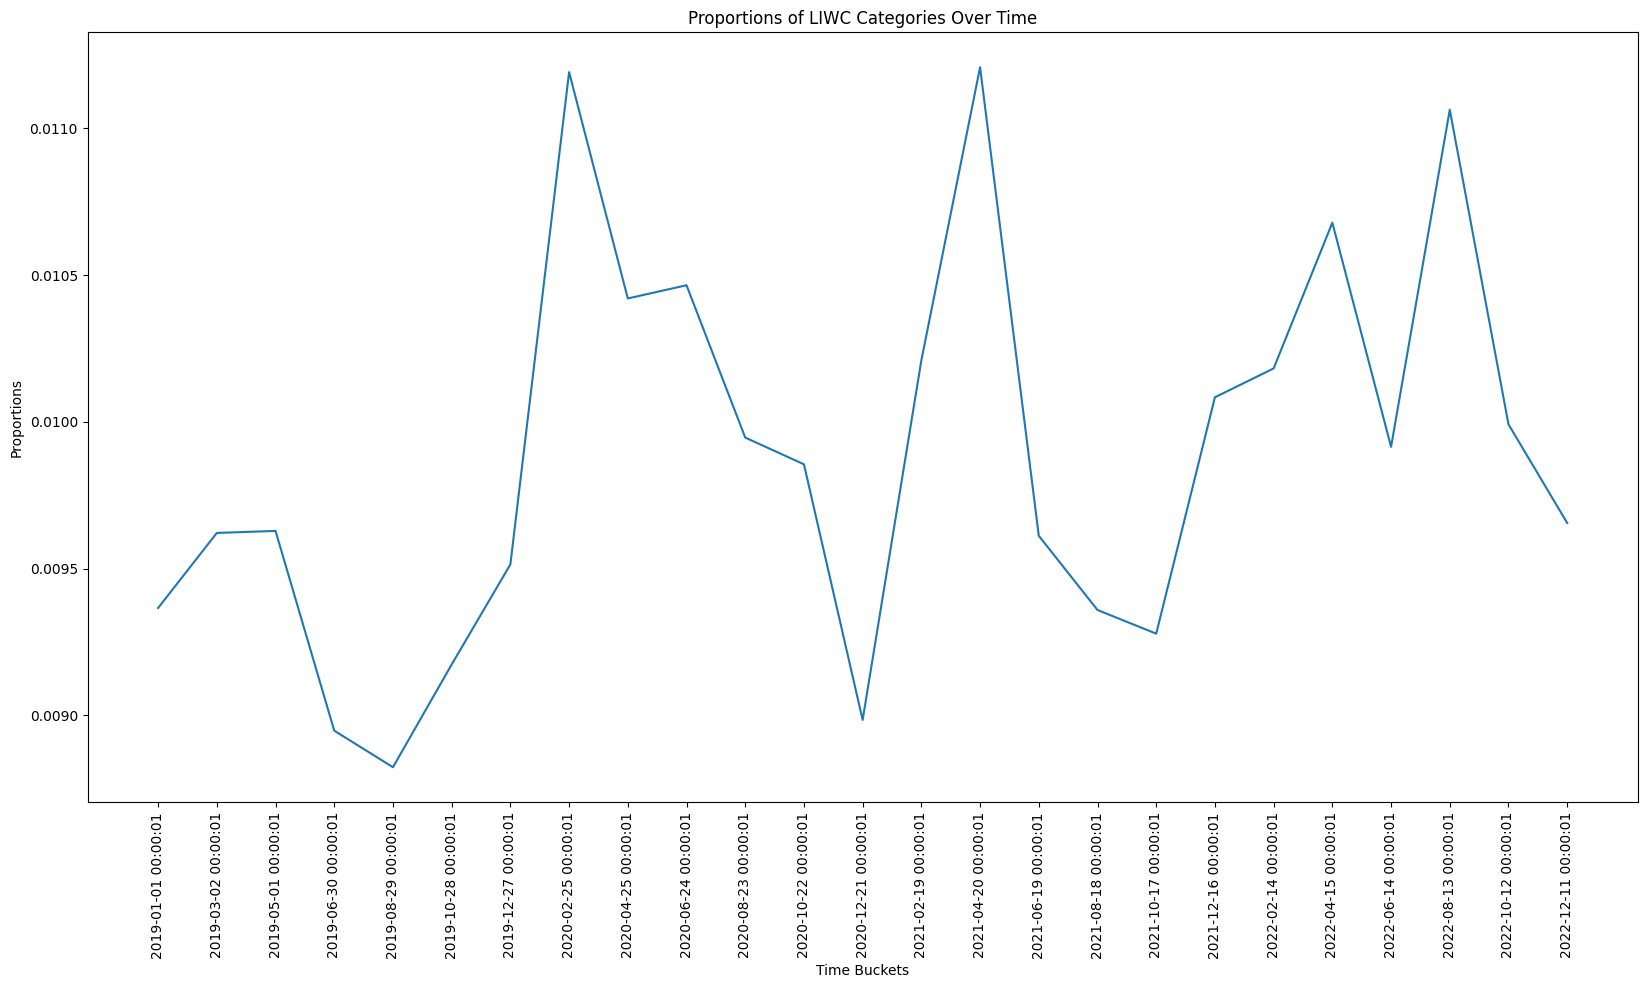

In [ ]:
from datetime import datetime

# Choose a LIWC category to graph, and graph the proportion of that LIWC category per time_bucket

# The LIWC category to graph
category = 'work'

# Total number of detected LIWC category counts
# For each row, sum the entire row, but dont sum the time_bucket column, give a list of the sums
total_counts = df_tb_liwc.sum(axis=1).tolist()

# Get the number of words detected with the selected LIWC category
category_counts = df_tb_liwc[category].tolist()

# Divide the two lists to get the proportion of the selected LIWC category per time_bucket
proportions = [category_counts[i] / total_counts[i] for i in range(len(total_counts))]

# Specify the figure size
plt.figure(figsize=(20, 10))

# Make it a bar graph
plt.plot(time_buckets[:-1], proportions, kind='bar')

# Give time buckets human readable labels
plt.xticks(time_buckets[:-1], [datetime.utcfromtimestamp(time_bucket).strftime('%Y-%m-%d %H:%M:%S') for time_bucket in time_buckets[:-1]], rotation=90)

# Add labels and title
plt.xlabel('Time Buckets')
plt.ylabel('Proportions')
plt.title(f'Proportions of {category} Over Time')

# Display the graph
plt.show()